In [1]:
# Script for training a denoiser
import os

os.environ['XLA_FLAGS']='--xla_gpu_cuda_data_dir=/gpfslocalsys/cuda/10.1.2'

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import haiku as hk
import jax
import optax
import jax.numpy as jnp
import numpy as onp
import pickle
from functools import partial

import tensorflow as tf
import tensorflow_datasets as tfds

from jax_lensing.inversion import ks93inv, ks93

from jax_lensing.models import UResNet18
from jax_lensing.models.normalization import SNParamsTree 

from jax_lensing.spectral import measure_power_spectrum, make_power_map

from astropy.io import fits

In [4]:
dataset = "kappatng"
weight_dir='/gpfswork/rech/xdy/commun/Remy2021/score_sn1.0_std0.2'

batch_size = 32
gaussian_prior = True

gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
ps_data_th = onp.load(gaussian_path).astype('float32')

sigma_gamma = 0.148
map_size = 360
resolution = 0.29
pixel_size = jnp.pi * resolution / 180. / 60. #rad/pixel

In [5]:
ps_data = onp.load(gaussian_path).astype('float32')
ell = jnp.array(ps_data[0,:])
# massivenu: channel 4
ps_halofit = jnp.array(ps_data[1,:] / pixel_size**2) # normalisation by pixel size
# convert to pixel units of our simple power spectrum calculator
#kell = ell / (360/3.5/0.5) / float(FLAGS.map_size)
kell = ell /2/jnp.pi * 360 * pixel_size / map_size
# Interpolate the Power Spectrum in Fourier Space
power_map_th = jnp.array(make_power_map(ps_halofit, map_size, kps=kell))

In [6]:
def forward_fn(x, s, is_training=False):
  denoiser = UResNet18(n_output_channels=1)
  return denoiser(x, s, is_training=is_training)

model = hk.without_apply_rng(hk.transform_with_state(forward_fn))

In [7]:
model_name = "model-40000.pckl"

with open(weight_dir+'/'+ model_name, 'rb') as file: 
    params, state, sn_state = pickle.load(file)

In [8]:
def log_gaussian_prior(map_data, sigma, ps_map):
  data_ft = jnp.fft.fft2(map_data) / float(map_size)
  return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (ps_map+sigma[0]**2))
gaussian_prior_score = jax.vmap(jax.grad(log_gaussian_prior), in_axes=[0,0, None])

In [9]:
def log_gaussian_prior_b(map_data, sigma):
    data_ft = jnp.fft.fft2(map_data) / float(map_size)
    return -0.5*jnp.sum(jnp.real(data_ft*jnp.conj(data_ft)) / (sigma[0]**2))

gaussian_prior_score_b = jax.vmap(jax.grad(log_gaussian_prior_b), in_axes=[0,0])

In [10]:
def score_fn(params, state, x, sigma, is_training=False):
    x = x.reshape((-1,360,360,2))
    ke = x[...,0]
    kb = x[...,1]
    
    if gaussian_prior:
        gsb = gaussian_prior_score_b(kb, sigma.reshape((-1,1,1)))
        gsb = jnp.expand_dims(gsb, axis=-1)

        # If requested, first compute the Gaussian prior
        gs = gaussian_prior_score(ke, sigma.reshape((-1,1,1)), power_map_th)
        gs = jnp.expand_dims(gs, axis=-1)
        #print((jnp.abs(sigma.reshape((-1,1,1,1)))**2).shape, (gs).shape)
        net_input = jnp.concatenate([ke.reshape((-1,360,360,1)), jnp.abs(sigma.reshape((-1,1,1,1)))**2 * gs],axis=-1)
        res, state = model.apply(params, state, net_input, sigma.reshape((-1,1,1,1)), is_training=is_training)
    else:
        res, state = model.apply(params, state, ke.reshape((-1,360,360,1)), sigma.reshape((-1,1,1,1)), is_training=is_training)
        gs = jnp.zeros_like(res)
        gsb = jnp.zeros_like(res)
    return _, res, gs, gsb

score_fn = partial(score_fn, params, state)

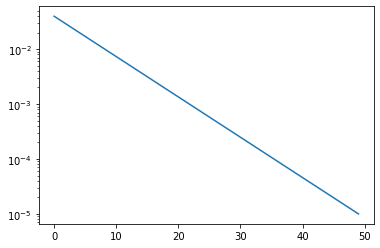

In [11]:
noise = 0.2
start_and_end_times = jnp.logspace(log10(0.99*noise**2),-5)

plot(start_and_end_times)
yscale('log')

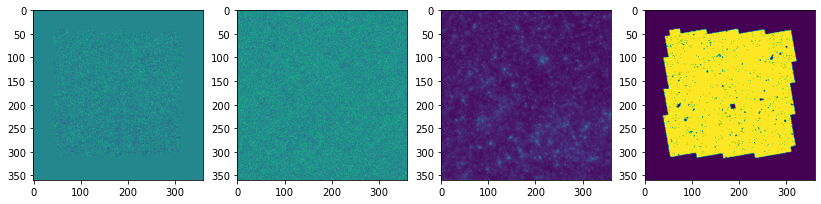

In [12]:
mask = fits.getdata('../../data/COSMOS/cosmos_full_mask_0.29arcmin360copy.fits').astype('float32')

convergence = fits.getdata('../../data/ktng/ktng_kappa360v2.fits').astype('float32')
meas_shear = jnp.stack(ks93inv(convergence, jnp.zeros_like(convergence)), axis=-1)
meas_shear += 0.148*np.random.randn(360,360,2)

#g1 = fits.getdata('../data/COSMOS/cosmos_full_e1_0.29arcmin360.fits').astype('float32').reshape([map_size, map_size, 1])
#g2 = fits.getdata('../data/COSMOS/cosmos_full_e2_0.29arcmin360.fits').astype('float32').reshape([map_size, map_size, 1])
#meas_shear = onp.concatenate([g1, g2], axis=-1)

mask = jnp.expand_dims(mask, -1)
sigma_mask = (1-mask)*10**3

masked_true_shear = meas_shear*mask

figure(figsize(14,5))
subplot(141)
imshow(masked_true_shear[..., 0])
subplot(142)
imshow(meas_shear[..., 1])
subplot(143)
imshow(convergence)
subplot(144)
imshow(mask[...,0])

In [13]:
def log_likelihood(x, sigma, meas_shear, mask):
    """ Likelihood function at the level of the measured shear
    """
    x = x.reshape((360, 360,2))
    ke = x[...,0]
    kb = x[...,1]

    model_shear = jnp.stack(ks93inv(ke, kb), axis=-1)
    
    return - jnp.sum((model_shear - meas_shear)**2/((sigma_gamma)**2 + sigma**2 + sigma_mask) )/2.

likelihood_score = jax.vmap(jax.grad(log_likelihood), in_axes=[0,0, None, None])

In [14]:
def score_prior(x, sigma):
    _, res, gaussian_score, gsb = score_fn(x.reshape(-1,360, 360,2), sigma.reshape(-1,1,1,1))
    ke = (res[..., 0:1] + gaussian_score).reshape(-1, 360*360)
    kb = gsb[...,0].reshape(-1, 360*360)
    return jnp.stack([ke, kb],axis=-1)

In [15]:
def total_score_fn(x, sigma):
    sl = likelihood_score(x, sigma, masked_true_shear, mask).reshape(-1, 360*360,2)
    sp = score_prior(x, sigma)
    return (sl + sp).reshape(-1, 360*360*2)
    #return (sp).reshape(-1, 360*360,2)

(50, 129600, 2)


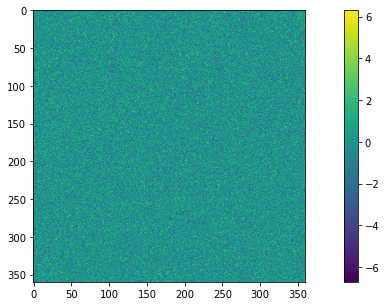

In [16]:
import numpy as onp

batch_size = 50
initial_temperature = 1.45

init_image = np.stack([initial_temperature*np.random.randn(batch_size,360*360), initial_temperature*np.random.randn(batch_size,360*360)], axis=-1)

imshow(init_image[0,...,0].reshape(360, 360))

print(init_image.shape)
colorbar()

In [17]:
from scipy import integrate

@jax.jit
def dynamics(t, x):
  x = x.reshape([-1,360,360,2])
  return - 0.5*total_score_fn(x, sigma=jnp.ones((batch_size,1,1,1))*jnp.sqrt(t)).reshape([-1])

In [18]:
%%time

noise = initial_temperature

start_and_end_times = jnp.logspace(log10(0.99*noise**2),-5, num=50)

solution = integrate.solve_ivp(dynamics, 
                               [noise**2,(0.0)], 
                               init_image.flatten(),
                               t_eval=start_and_end_times)

CPU times: user 54min 44s, sys: 50min 44s, total: 1h 45min 29s
Wall time: 29min 41s


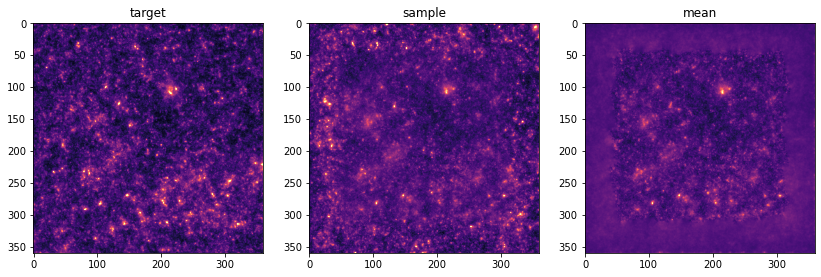

In [19]:
sol = solution.y[:,-1].reshape([batch_size,360,360,2])[...,0]

kwargs = dict(vmin=-0.05, vmax=0.2, cmap='magma')

subplot(131)
title('target')
imshow(convergence, **kwargs)
subplot(132)
title('sample')
imshow(sol[0,...], **kwargs)
subplot(133)
title('mean')
imshow(sol.mean(axis=0), **kwargs)

## Power Spectrum
Compare to fiducial power spectrum, Gaussian posterior sample and target $\kappa$ map

In [20]:
mps = jax.vmap(measure_power_spectrum, in_axes=[0,None])
ell_post, cl_post = mps(sol, pixel_size)
cl_post_mean = cl_post.mean(0)
cl_post_std = cl_post.std(0)

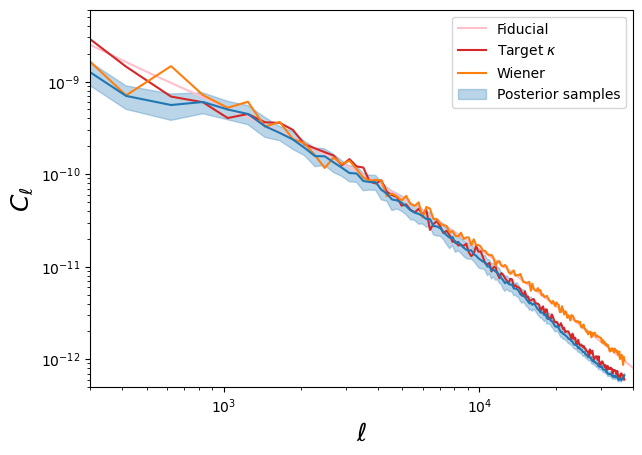

In [21]:
figure(figsize=(7,5), dpi=100)

kwargs = dict(linewidth=1.5)

gaussian_path = "../../data/ktng/ktng_PS_theory.npy"
ps_data_th = np.load(gaussian_path).astype('float32')
plot(ps_data_th[0,:], ps_data_th[1,:], color='pink', label='Fiducial', **kwargs)

l_true, C_true = measure_power_spectrum(convergence, pixel_size)
loglog(l_true, C_true, color='tab:red', label=r'Target $\kappa$', **kwargs)

wiener = np.load('gaussian_samples.npy')
l_true, C_true = measure_power_spectrum(wiener[0,...], pixel_size)
loglog(l_true, C_true, color='tab:orange', label='Wiener', **kwargs)

plot(ell_post[0,...], cl_post_mean, color='tab:blue', **kwargs)
fill_between(ell_post[0,...], cl_post_mean-cl_post_std,
             cl_post_mean+cl_post_std, color='tab:blue' ,alpha=0.3, label='Posterior samples')

legend()
ylim(5.e-13,6e-9)
xlim(300,4e4)
xscale('log')
yscale('log')
ylabel(r'$C_\ell$', fontsize=18)
xlabel(r'$\ell$', fontsize=18)

savefig('ps-ODE-comparison-1.pdf')

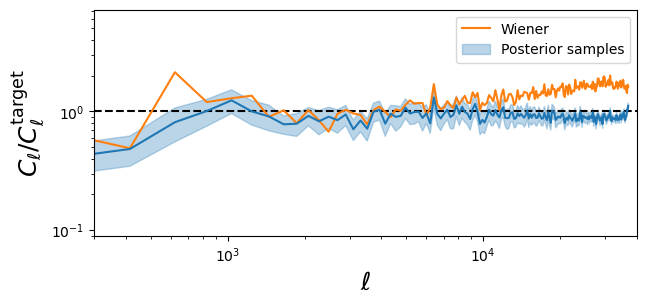

In [22]:
figure(figsize=(7,3), dpi=100)

kwargs = dict(linewidth=1.5)

hlines(y=1., xmin=300,xmax=4e4, linestyle='--', color='k')

l_true, C_true = measure_power_spectrum(convergence, pixel_size)

l_true, C_wiener = measure_power_spectrum(wiener[0,...], pixel_size)
plot(l_true, C_wiener/C_true, color='tab:orange', label='Wiener', **kwargs)


ell_post, cl_post = mps(sol, pixel_size)
mean = (cl_post/C_true).mean(0)
std = (cl_post/C_true).std(0)
plot(l_true, mean, color='tab:blue', **kwargs)
fill_between(l_true, mean-std,
             mean+std, color='tab:blue' ,alpha=0.3, label='Posterior samples')

legend()
xlim(300,4e4)
xscale('log')
yscale('log')
ylabel(r'$C_\ell/C_\ell^\mathrm{target}$', fontsize=18)
xlabel(r'$\ell$', fontsize=18)
savefig('ps-ODE-comparison-2.pdf')